#Fine-Tunning du modèle Resnet101 ainsi que l'essaie de la capture de l'incohérence de la réflexion de la lumière

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FONCTION RETINEX

In [ ]:
import numpy as np
import cv2

def singleScaleRetinex(img, sigma):

    retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), sigma))

    return retinex

def multiScaleRetinex(img, sigma_list):

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        retinex += singleScaleRetinex(img, sigma)

    retinex = retinex / len(sigma_list)

    return retinex

def colorRestoration(img, alpha, beta):

    img_sum = np.sum(img, axis=2, keepdims=True)

    color_restoration = beta * (np.log10(alpha * img) - np.log10(img_sum))

    return color_restoration

def simplestColorBalance(img, low_clip, high_clip):

    total = img.shape[0] * img.shape[1]
    for i in range(img.shape[2]):
        unique, counts = np.unique(img[:, :, i], return_counts=True)
        current = 0
        for u, c in zip(unique, counts):
            if float(current) / total < low_clip:
                low_val = u
            if float(current) / total < high_clip:
                high_val = u
            current += c

        img[:, :, i] = np.maximum(np.minimum(img[:, :, i], high_val), low_val)

    return img

def MSRCR(img, sigma_list, G, b, alpha, beta, low_clip, high_clip):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)
    img_color = colorRestoration(img, alpha, beta)
    img_msrcr = G * (img_retinex * img_color + b)

    for i in range(img_msrcr.shape[2]):
        img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                             (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                             255

    img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
    img_msrcr = simplestColorBalance(img_msrcr, low_clip, high_clip)

    return img_msrcr



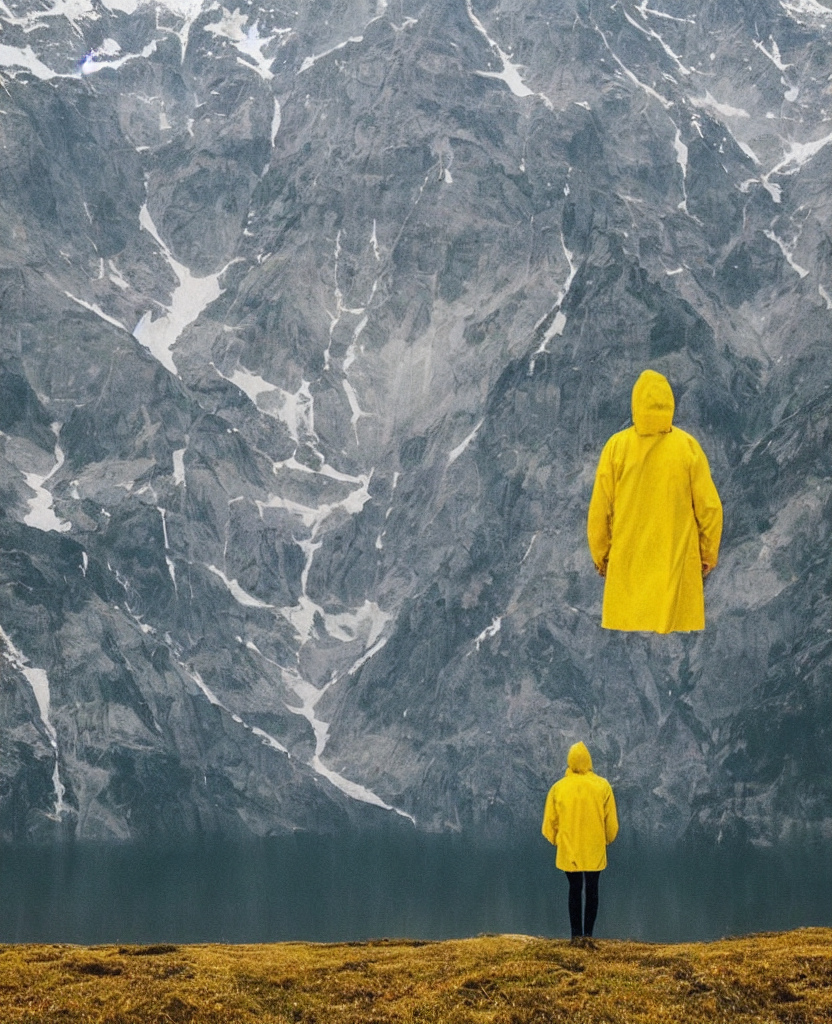

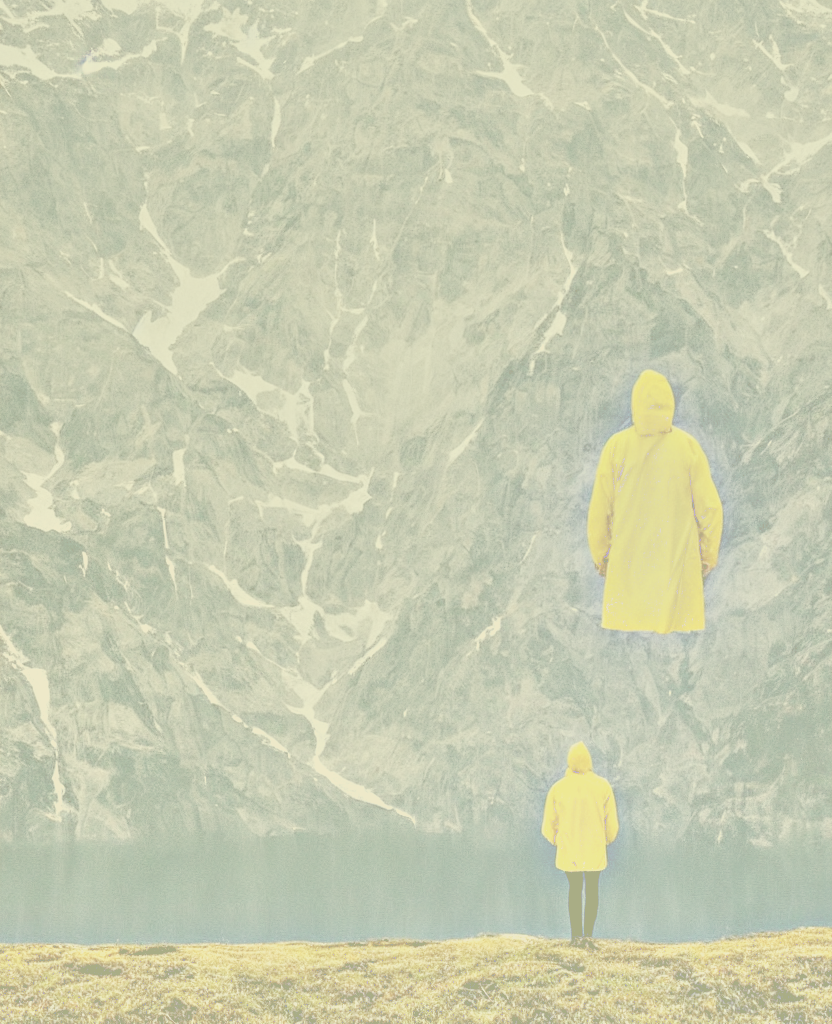

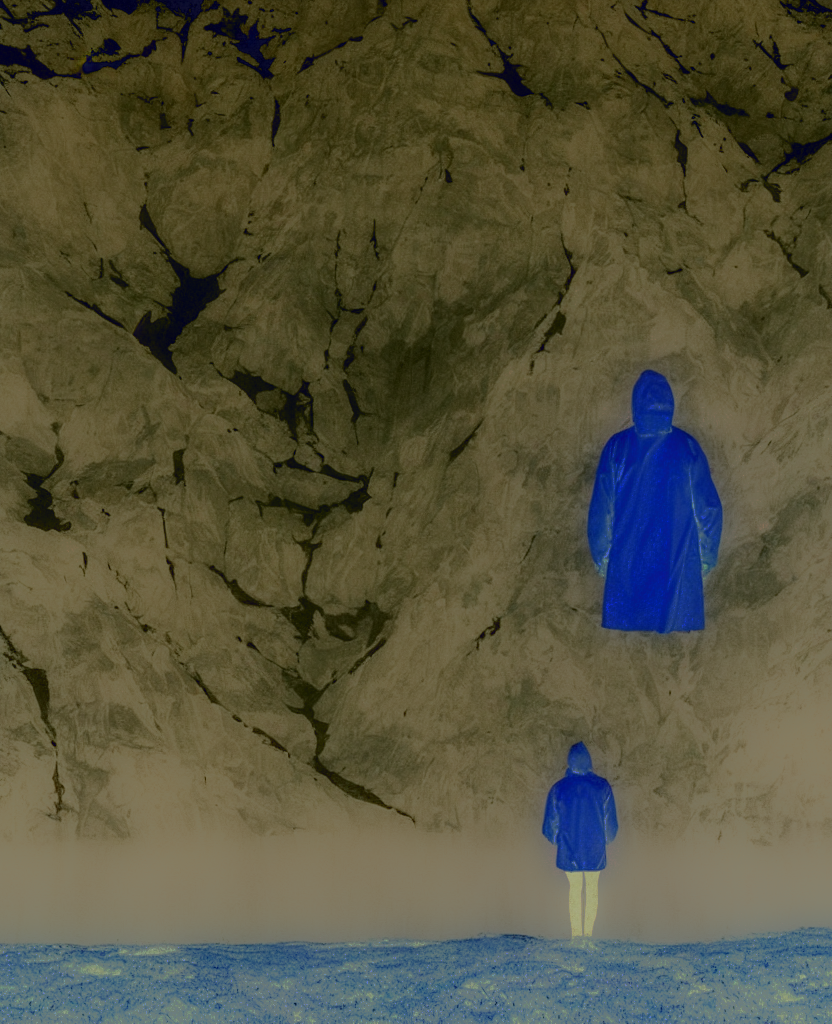

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

img = cv2.imread('/content/drive/MyDrive/Projet_Vision/image/val/1/RGB_fake_12.png')

img_msrcr = MSRCR(img,[15, 80, 250], 5.0, 25.0, 125.0, 46.0, 0.01, 0.99)

# Calculer la différence absolue
absolute_difference = cv2.absdiff(img, img_msrcr)

# Afficher l'image originale et l'image corrigée
cv2_imshow(img)
cv2_imshow(img_msrcr)
cv2_imshow(absolute_difference)
cv2.waitKey(0)
cv2.destroyAllWindows()


#Sauvegarde de l'image issus de la différence absolue entre l'image sans pré-traitement et avec pré-traitement

In [ ]:
import cv2
import os

def apply_msrcp_and_save(input_folder, output_folder):
    # Liste de fichiers dans le dossier source
    files = os.listdir(input_folder)

    for file in files:
        # Chemin complet du fichier source
        input_path = os.path.join(input_folder, file)

        # Charger l'image
        img = cv2.imread(input_path)

        # Appliquer la correction MSRCP
        img_msrcp = MSRCP(img,[15, 80, 250],0.01,0.99)
        absolute_difference = cv2.absdiff(img, img_msrcp)

        # Chemin complet du fichier de destination
        output_path = os.path.join(output_folder, file)

        # Sauvegarder l'image corrigée
        cv2.imwrite(output_path, absolute_difference)

        print(f"Image corrigée sauvegardée dans {output_path}")


# Chemin vers le dossier source
input_folder = '/content/drive/MyDrive/Projet_Vision/image_vision/random/stablediff_test/1'

# Chemin vers le dossier de destination (où les images corrigées seront sauvegardées)
output_folder = '/content/drive/MyDrive/Projet_Vision/image_vision/random/procédé_stablediff_test/1'

# Appeler la fonction pour appliquer MSRCP et sauvegarder les images
apply_msrcp_and_save(input_folder, output_folder)


#Traitement de l'image

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
}


#Affectation des différents dataset à leur dataloader respectives

In [ ]:
import os

class CustomDataset(Dataset):
    def __init__(self, real_folder, proc_folder, label, transform=None):
        self.real_folder = os.path.join(real_folder)
        self.proc_folder = os.path.join(proc_folder)
        self.label = label
        self.transform = transform

        # Obtenir la liste des fichiers réels dans le sous-dossier correspondant
        real_filenames = [filename for filename in os.listdir(self.real_folder) if filename.endswith(".png")]

        # Construire les chemins des fichiers réels et procédé correspondants
        self.real_paths = [os.path.join(self.real_folder, filename) for filename in real_filenames]
        self.proc_paths = [os.path.join(self.proc_folder, filename) for filename in real_filenames]

    def __len__(self):
        return len(self.real_paths)

    def __getitem__(self, idx):
        real_image_path = self.real_paths[idx]
        proc_image_path = self.proc_paths[idx]

        real_image = datasets.folder.default_loader(real_image_path)
        proc_image = datasets.folder.default_loader(proc_image_path)

        if self.transform:
            real_image = self.transform(real_image)
            proc_image = self.transform(proc_image)

        return (real_image, proc_image, self.label)


image_datasets = {

    'test':
    datasets.ImageFolder('/content/drive/MyDrive/Projet_Vision/image/test', data_transforms['validation']),

}

# Création des datasets
train_dataset_0 = CustomDataset("/content/drive/MyDrive/Projet_Vision/image/train/0", '/content/drive/MyDrive/Projet_Vision/image/procédé_entrainement/0', label=0, transform=data_transforms['train'])
train_dataset_1 = CustomDataset("/content/drive/MyDrive/Projet_Vision/image/train/1", '/content/drive/MyDrive/Projet_Vision/image/procédé_entrainement/1', label=1, transform=data_transforms['train'])

# Fusionner les datasets pour chaque classe
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])


# Création des datasets
val_dataset_0 = CustomDataset('/content/drive/MyDrive/Projet_Vision/image/val/0', '/content/drive/MyDrive/Projet_Vision/image/procédé_validation/0', label=0, transform=data_transforms['validation'])
val_dataset_1 = CustomDataset('/content/drive/MyDrive/Projet_Vision/image/val/1', '/content/drive/MyDrive/Projet_Vision/image/procédé_validation/1', label=1, transform=data_transforms['validation'])

# Fusionner les datasets pour chaque classe
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])

# Création des datasets
test_dataset_0 = CustomDataset('/content/drive/MyDrive/Projet_Vision/image/test/0', '/content/drive/MyDrive/Projet_Vision/image/procédé_test/0', label=0, transform=data_transforms['validation'])
test_dataset_1 = CustomDataset('/content/drive/MyDrive/Projet_Vision/image/test/1', '/content/drive/MyDrive/Projet_Vision/image/procédé_test/1', label=1, transform=data_transforms['validation'])

# Fusionner les datasets pour chaque classe
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Créer les DataLoader en utilisant le nouveau Dataset
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset,
                                         batch_size=32,
                                         shuffle=True,
                                         num_workers=0),
    'validation': torch.utils.data.DataLoader(val_dataset,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0),
    'test': torch.utils.data.DataLoader(test_dataset,
                                        batch_size=32,
                                        shuffle=False,
                                        num_workers=0)
}


In [ ]:
dataloaders["train"].dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Fine-Tunning et initialisation du modèle Resnet101

In [ ]:
#model = models.resnet101().to(device)

#for param in model.parameters():
 #param.requires_grad = False
#model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#model.fc = nn.Sequential(
             #  nn.Linear(2048, 128),
             #  nn.ReLU(inplace=True),
             #  nn.Linear(128, 2))

class CustomResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet101(weights = models.ResNet101_Weights.DEFAULT)  # You can choose a different ResNet variant

        # Adjust the first layer to accept 6 channels
        # Assuming the input image size is (224, 224)
        self.resnet.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the fully connected layer for binary classification
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)
        )
        # Freeze all parameters by default
        for param in self.resnet.parameters():
            param.requires_grad = True

        # Specify layers to be trained
        #layer1 = "layer4"
        layer2 = "layer3"
        layer3 = "layer2"
        layer4 = "layer1"
        for name, param in self.resnet.named_parameters():
            #if layer1 in name:
                #param.requires_grad = True
            if layer2 in name:
              param.requires_grad = False
            if layer3 in name:
              param.requires_grad = False
            if layer4 in name:
              param.requires_grad = False
            print(name, param.requires_grad)

    def forward(self, x1, x2):
        # Concatenate the two images along the channel dimension
        x = torch.cat((x1, x2), dim=1)

        # Forward pass through the modified ResNet
        return self.resnet(x)

In [ ]:
model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

#Fonction pour l'entrainement du modèle

In [ ]:
import copy
import torch

def train_model(model, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs1, inputs2, labels in dataloaders[phase]:
                inputs1 = inputs1.to(device)
                inputs2 = inputs2.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs1, inputs2)  # Modifiez en fonction de votre modèle
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs1.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'validation':
                val_loss.append(epoch_loss)
            if phase == 'train':
                train_loss.append(epoch_loss)

            # Deep copy the model if it has the best validation accuracy
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, val_loss, train_loss



In [ ]:
model_trained, val_loss, train_loss = train_model(model, criterion, optimizer, num_epochs=10)

#Affichage de la loss

In [ ]:
epochs = range(1, len(val_loss) + 1)

# Plotting the loss values
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Calcul de l'accuracy ainsi que de la matrice de convolution pour l'ensemble de test

In [ ]:
model = model_trained

In [ ]:
torch.save(model_trained.state_dict(), '/content/drive/MyDrive/Projet_Vision/weights6.h5')

In [ ]:
model = CustomResNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Projet_Vision/weights6.h5'))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()

# Define variables for keeping track of accuracy and total tested samples
correct = 0
total = 0
true_labels = []
predicted_labels = []

class_1_counter = 0

# Iterate through the test dataset
for inputs1, inputs2, labels in dataloaders["test"]:
    inputs1 = inputs1.to(device)
    inputs2 = inputs2.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():  # No need to calculate gradients during inference
        outputs = model(inputs1, inputs2)

    _, predicted = torch.max(outputs.data, 1)
    print(predicted)

    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

    # Calculate accuracy
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Calculate overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()